# Importing Libraries

In [ ]:
!pip install torchmetrics
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torchvision
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torchmetrics import Accuracy, Recall, Precision, F1Score, AUROC, MeanSquaredError
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Loading Dataset

In [36]:
reports = pd.read_csv('/kaggle/input/indiana-university-dataset/indiana_reports.csv')
projections = pd.read_csv('/kaggle/input/indiana-university-dataset/indiana_projections.csv')
img_dir = '/kaggle/input/indiana-university-dataset/images_normalized'

# Converting Diseases into a Single Class (abnormal)

In [ ]:
reports['Problems'] = reports['Problems'].apply(lambda x: 'normal' if x == 'normal' else 'abnormal')
df = pd.merge(projections[['uid', 'filename']],
                     reports[['uid', 'Problems']],
                     on='uid')
df = df.drop_duplicates()
df.head(3)

# Converting Disease into abnormal (1)

In [ ]:
df['Problems'] = df['Problems'].apply(lambda x: 0 if x.strip().lower() == 'normal' else 1)

# Drop the original `Problems` column
df = df[['filename', 'Problems']]

# Display the first few rows of the processed DataFrame
df.head()

# Image Counts for the Target Classes

In [39]:
from collections import Counter

# Count the occurrences of each class
class_counts = Counter(df['Problems'])

# Display the class distribution
print(class_counts)

Counter({1: 4771, 0: 2695})


# Visualizing Medical Images

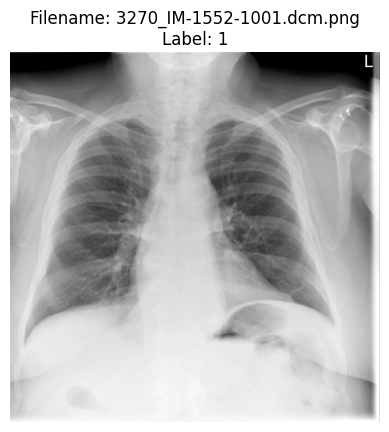

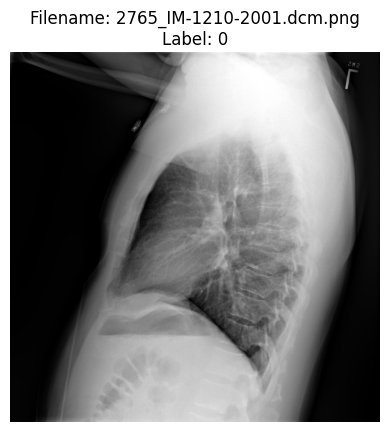

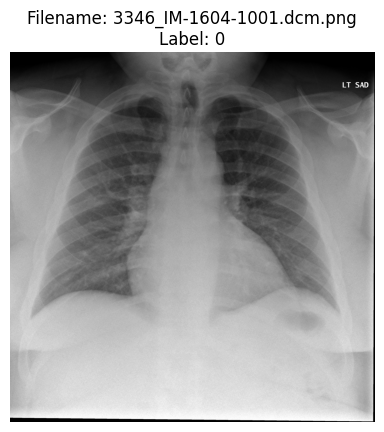

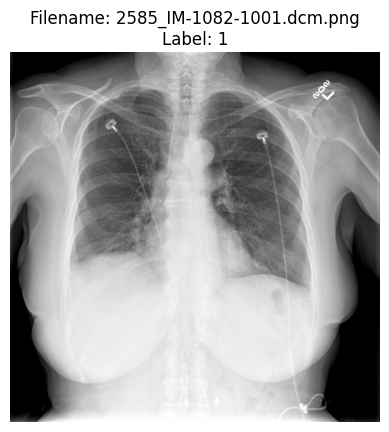

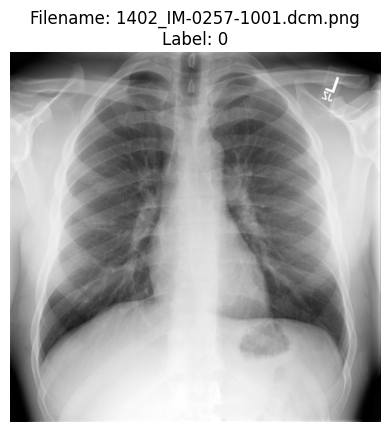

Image size for 1402_IM-0257-1001.dcm.png: (2051, 2048)


In [40]:
num_samples = 5  # Number of samples to verify
samples = df.sample(num_samples)  # Randomly select entries

for _, row in samples.iterrows():
    filename = row['filename']
    label = row['Problems']  # Label column
    file_path = os.path.join(img_dir, filename)

    # Open and display the image
    if os.path.exists(file_path):
        image = Image.open(file_path)
        plt.imshow(image, cmap='gray')
        plt.title(f"Filename: {filename}\nLabel: {label}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Image not found: {file_path}")

print(f"Image size for {row['filename']}: {image.size}")  # Prints (width, height))

# Balancing the Target Classes

In [41]:
def balance_dataset(df, minority_class):
    # Calculate the counts of each class
    class_counts = Counter(df['Problems'])
    required_augmentations = class_counts[1] - class_counts[0]

    # Balance the dataset by duplicating rows of the minority class
    minority_rows = df[df['Problems'] == minority_class]
    augmented_df = minority_rows.sample(n=required_augmentations, replace=True, random_state=42)
    
    # Combine the original dataset with the augmented rows
    balanced_df = pd.concat([df, augmented_df], ignore_index=True)
    return balanced_df

# PyTorch Dataset

In [42]:
class MedicalImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform_original, transform_augmented, minority_class=0):
       
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform_original = transform_original
        self.transform_augmented = transform_augmented
        self.minority_class = minority_class

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Retrieve image path and label
        img_name = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Load the image
        image = Image.open(img_path).convert('RGB')
        
        # Apply appropriate transformations
        if label == self.minority_class:
            image = self.transform_augmented(image)
        else:
            image = self.transform_original(image)
        
        return image, label

# Transformation

In [43]:
transform_original = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
])

# Augmentations for minority class
transform_augmented = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

In [44]:
balanced_df = balance_dataset(df, minority_class=0)

# Step 5: Create Dataset and DataLoader
dataset = MedicalImageDataset(
    dataframe=balanced_df,
    image_dir=img_dir,
    transform_original=transform_original,
    transform_augmented=transform_augmented,
    minority_class=0
)

In [ ]:
balanced_class_counts = Counter(balanced_df['Problems'])
print("Class distribution in balanced dataset:")
print(balanced_class_counts)

# Splitting Dataset

In [46]:
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Loading Datasets

In [47]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ResNet18

In [48]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout with 50% probability
            nn.Linear(self.model.fc.in_features, 2)  # Binary classification
        )  # Binary classification

    def forward(self, x):
        return self.model(x)

# Device, Optimizer, and Loss Function

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Evaluating a Model

In [50]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Accuracy: {correct/total:.4f}")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Train Loss: 0.1408, Val Loss: 1.3689, Val Accuracy: 0.6130
Epoch 2/10, Train Loss: 0.0871, Val Loss: 0.0562, Val Accuracy: 0.9797
Epoch 3/10, Train Loss: 0.0743, Val Loss: 0.0736, Val Accuracy: 0.9756
Epoch 4/10, Train Loss: 0.0651, Val Loss: 0.0723, Val Accuracy: 0.9728
Epoch 5/10, Train Loss: 0.0511, Val Loss: 0.1555, Val Accuracy: 0.9375
Epoch 6/10, Train Loss: 0.0663, Val Loss: 0.0989, Val Accuracy: 0.9619
Epoch 7/10, Train Loss: 0.0580, Val Loss: 0.0855, Val Accuracy: 0.9752
Epoch 8/10, Train Loss: 0.0493, Val Loss: 0.0664, Val Accuracy: 0.9759
Epoch 9/10, Train Loss: 0.0381, Val Loss: 0.1297, Val Accuracy: 0.9518
Epoch 10/10, Train Loss: 0.0401, Val Loss: 0.0462, Val Accuracy: 0.9836


# Confusion Matrix

Confusion Matrix:
 [[1442   10]
 [  35 1376]]


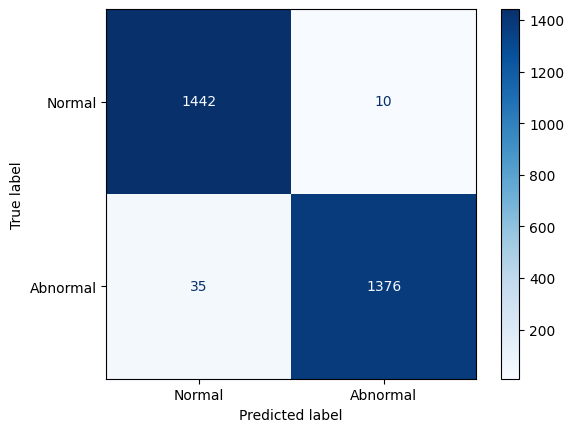

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap="Blues", values_format='d')

print("Confusion Matrix:\n", cm)

# Generalization Analysis

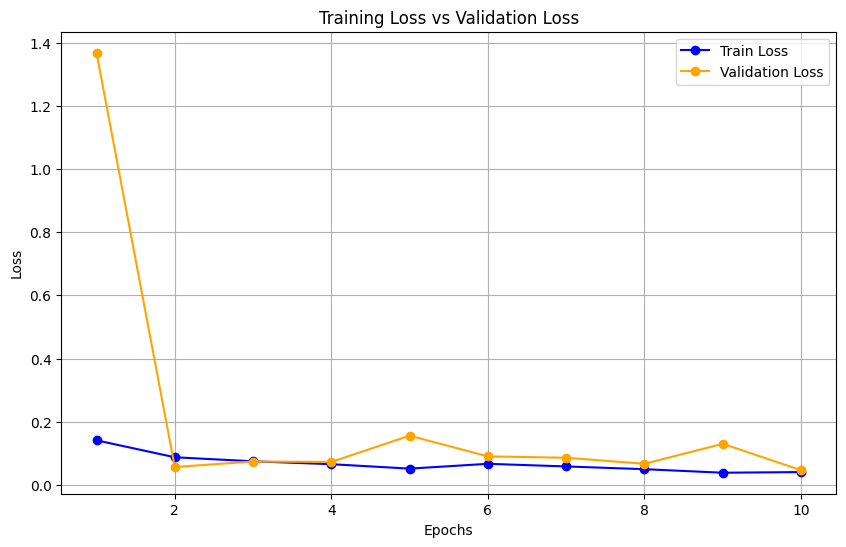

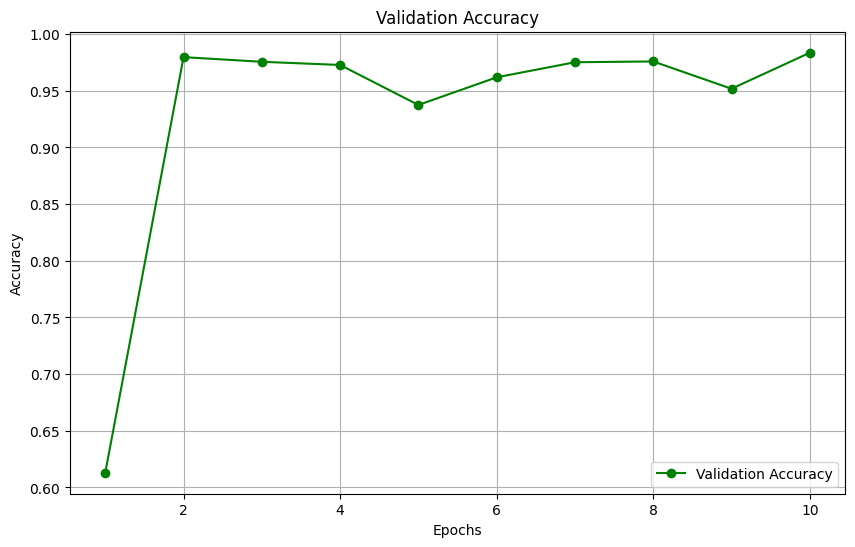

In [53]:
import matplotlib.pyplot as plt

# Data for the epochs
epochs = list(range(1, 11))  # Epochs 1 to 10
train_loss = [0.1408, 0.0871, 0.0743, 0.0651, 0.0511, 0.0663, 0.0580, 0.0493, 0.0381, 0.0401]
val_loss = [1.3689, 0.0562, 0.0736, 0.0723, 0.1555, 0.0899, 0.0855, 0.0664, 0.1297, 0.0462]
val_accuracy = [0.6130, 0.9797, 0.9756, 0.9728, 0.9375, 0.9619, 0.9752, 0.9759, 0.9518, 0.9836]

# Plot Training Loss and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='orange')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
